In [1]:
from __future__ import annotations
from typing import List
import csv

class Group:
    def __init__(self, title: str = None, total_time: float = None, members: List[str] = None):
        self.total_time = total_time
        self.title = title
        self.members = members if members is not None else []
    
    def __str__(self):
        members_str = ", ".join(self.members)
        res = f"Group time: "
        if self.title:
            res += f"{self.title}: "
        res += f"{self.total_time}\n"
        if sum([int(member) for member in self.members if member != '']) > 0:
            res += f"Members: {members_str}\n"
        return res

class Time:
    def __init__(self, total_time: float = None, groups: List[Group] = None):
        self.total_time = total_time
        self.groups = groups if groups is not None else []
    
    def __str__(self):
        return f"Total time: {self.total_time}\nGroups:\n{''.join([str(group) for group in self.groups])}"
    
    def get_publishable_results(self):
        return f"#### Time:\nTotal time: {self.total_time}\nGroups:\n{''.join([str(group) for group in self.groups])}"


class Reply:
    def __init__(self, row, survey:Survey = None):
        index = 0
        index_dict_iterator = iter(survey.index_dict)

        # # print newline separated entire row
        # for i in range(len(row)):
        #     print(f"{i}: {row[i]} ({survey.labels[i]})")
        
        section = next(index_dict_iterator)     # section = 'metadata'
        members = survey.index_dict[section]    # members = ['Response ID', ...]
        member_iterator = iter(members)         # member_iterator = iter(['Response ID', ...])
        end = index + len(members)
        while index < end:
            key = next(member_iterator)       # value = 'Response ID'
            value = row[index]
            if key in survey.answer_code_dict:
                if value in survey.answer_code_dict[key]:
                    value = survey.answer_code_dict[key][value]
            if key == "Response ID":
                self.response_id = value
            elif key == "Date submitted":
                self.date_submitted = value
            elif key == "Last page":
                self.last_page = value
            elif key == "Start language":
                self.start_language = value
            elif key == "Seed":
                self.seed = value
            elif key == "Date started":
                self.date_started = value
            elif key == "Date last action":
                self.date_last_action = value
            elif key == "Referrer URL":
                self.referrer_url = value
            elif key == "tool" or key == "tool_other":
                # check if self.tool exists. If not, create it as row[index]
                if not hasattr(self, "tool"):
                    self.tool = value
                elif self.tool == "-oth-":
                    self.tool = value
            index += 1

        self.scores = []

        section = next(index_dict_iterator)     # section = 'requirements'
        members = survey.index_dict[section]    # members = [1, 2, ...]
        end = index + len(members)
        while index < end:
            self.scores.append(row[index])
            index += 1

        section = next(index_dict_iterator)     # section = 'requirements'
        members = survey.index_dict[section]    # members = ['age', 'education', ...]
        member_iterator = iter(members)         # member_iterator = iter(['Response ID', ...])
        end = index + len(members)
        while index < end:
            key = str(next(member_iterator))  # value = 'Response ID'
            value = row[index]
            if key in survey.answer_code_dict:
                if value in survey.answer_code_dict[key]:
                    value = survey.answer_code_dict[key][value]
            if key == "age":
                self.age = value
            elif key == "education" or key == "education_other":
                # check if self.tool exists. If not, create it as row[index]
                if not hasattr(self, "education"):
                    self.education = value
                elif  self.education == "-oth-":
                    self.education = value
            elif key == "survey_count":
                self.survey_count = value
            elif key == "experience":
                self.experience = value
            elif key == "comments":
                self.comments = value
            index += 1

        # the time is an object and holds nested values for the 10 groups
        self.time = Time()
        self.time.total_time = row[index]
        index += 1

        # iterate over groups
        while index < len(row)-1:
            if survey.labels[index].startswith("Group time:"):
                title = survey.labels[index].replace("Group time: ", "")
                self.time.groups.append(Group(title))
                self.time.groups[-1].total_time = row[index]
            else:
                self.time.groups[-1].members.append(row[index])
            index += 1

        # check for reported errors
        self.check_reported_errors()
        
    def __str__(self):
        res = f"Reply: {self.response_id}\nDate submitted: {self.date_submitted}\nLast page: {self.last_page}\nStart language: {self.start_language}\nSeed: {self.seed}\nDate started: {self.date_started}\nDate last action: {self.date_last_action}\nRefer0rer URL: {self.referrer_url}\n"
        if hasattr(self, "tool"):
            res += f"Tool: {self.tool}\n"
        res += f"Scores: {self.scores}\nAge: {self.age}\nEducation: {self.education}\nSurvey count: {self.survey_count}\nExperience: {self.experience}\nComments: {self.comments}\n"
        res += f"{self.time}\n"
        return res
    
    def check_reported_errors(self):
        if hasattr(self, "tool"):
            if self.tool == "-oth-" or self.tool == "":
                print(f"Error: {self.response_id} reported tool as other, but did not specify the tool.")
        if hasattr(self, "education"):
            if self.education == "-oth-" or self.education == "":
                print(f"Error: {self.response_id} reported education as other, but did not specify the education.")
        # A respondent reported to have accidentally selected the wrong tool when actually evaluating the "SWARM-SLR 2024-01".
        # They reported on 2024-01-15 to have submitted late friday morning on the 2024-01-12.
        # A response fitting their described time, time taken, tool selection etc. was found and and the exact submission time was reported to them: 2024-01-12 10:27:21.
        # They confirmed that this was their response.
        # This specific response is hence updated to reflect the correct tool.
        if self.date_submitted == "2024-01-12 10:27:21":
            self.tool = "SWARM-SLR 2024-01"

        # Once this issue was known, the channels used to communicated the survey were informed to check if they had made the same error.
        # Indicators are a total time exceeding 20 minutes and especially comments referencing the "approach"/"method" or "SWARM-SLR"
            
        # One other response reported the same issue.
        # They reported their time, tool selection and demographic data, which mapped to the response with the submission time 2024-01-12 12:25:56.
        # This specific response is hence updated to reflect the correct tool.
        if self.date_submitted == "2024-01-12 12:25:56":
            self.tool = "SWARM-SLR 2024-01"

        
        # In the meantime, a hint is presented, identifying unconfirmed surveys taking more than 20 minutes, without referring to "SWARM-SLR"
        # IDs confirmed are excluded
        confiremd_ids = [
            21,             # Submitted 2023, before the SWARM-SLR toolset was proposed
            31,             # Submitted 2023, before the SWARM-SLR toolset was proposed
            # 42,           # Hint: 42 took 21 minutes and might have selected the wrong tool (Zotero).
            # 58,           # Hint: 58 took 72 minutes and might have selected the wrong tool (Zotero).
        ]
        # The confirmed IDs show that the indicator "took more than 20 minutes" does not imply that the tool was selected incorrectly.
        # A thoughtful participant might have taken more time to evaluate any other tool as well.
        if float(self.time.total_time) > 1200:
            if int(self.response_id) not in confiremd_ids:
                if hasattr(self, "tool") and not "SWARM-SLR" in self.tool:
                    print(f"Hint: {self.response_id} took {round(float(self.time.total_time)/60)} minutes and might have selected the wrong tool ({self.tool}).")
    
    def get_publishable_results(self):
        res = f"### Response ID: {self.response_id}\n"
        if hasattr(self, "tool"):
            res += f"#### Tool: {self.tool}\n"
        res += f"#### Scores:\n{self.scores}\n"
        res += f"{self.time.get_publishable_results()}\n"
        return res

def remove_rogue_linebreaks(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    new_lines = []
    current_line = ""
    for line in lines:
        current_line += line.strip()
        if current_line.count('"') % 2 == 0:  # if count of " is even
            new_lines.append(current_line)
            current_line = ""

    with open(filename, 'w') as file:
        file.write('\n'.join(new_lines))

class Survey:
    # different types of survey, with different selection_last_index and deletions
    types = {
        "default": {
            "index_dict": {
                "metadata": [
                    "Response ID",
                    "Date submitted",
                    "Last page",
                    "Start language",
                    "Seed",
                    "Date started",
                    "Date last action",
                    "Referrer URL",
                ],
                "requirements" : [i for i in range(65)],
                "demographics": [
                    "age",
                    "education",
                    "education_other",
                    "survey_count",
                    "experience",
                    "comments",
                ],
                "time" : -1,
            },
            "deletions": [],
            "expected_last_page": "10",
        },
        "555283": {
            "index_dict": {
                "metadata": [
                    "Response ID",
                    "Date submitted",
                    "Last page",
                    "Start language",
                    "Seed",
                    "Date started",
                    "Date last action",
                    "Referrer URL",
                ],
                "requirements" : [i for i in range(65)],
                "demographics": [
                    "age",
                    "education",
                    "education_other",
                    "survey_count",
                    "experience",
                    "comments",
                ],
                "time" : -1,
            },
            "answer_code_dict": {
                "tool": {
                    "A1": "CADIMA",
                    "A2": "Large Language Models (LLM) like ChatGPT, Bing",
                    "A3": "Open Research Knowledge Graph (ORKG)",
                    "A4": "Google Scholar",
                    "A5": "Semantic Scholar",
                    "A6": "Open Knowledge Maps (OKMaps)",
                    "A7": "ConnectedPapers",
                    "A8": "Python",
                    "A9": "Natural Language Processing (NLP) libraries like NLTK, spaCy, FLAIR",
                    "A10": "PDF miners like pdfminer, pypdf2",
                    "A11": "Zotero",
                    "A12": "LaTeX",
                    "A13": "SciKGTeX",
                    "A14": "Colandr",
                    "A15": "Cochrane RevMan",
                    "A16": "covidence",
                    "A17": "rayyan",
                    "A18": "Health Assessment Workspace Collaborative (HAWC) Project",
                    "A19": "metagear",
                    "A20": "Parsifal",
                    "A21": "Systematic Review Data Repository Plus (SRDR+)",
                    "A22": "Sciome",
                    "A23": "Systematic Review Facility (SyRF)",
                    "A24": "interactive Summary of Findings (iSoF)",
                    "A25": "ReLiS",
                    "A26": "SESRA",
                    "A27": "Right Review",
                    "A28": "JBI SUMARI",
                    "A29": "Research Rabbit",
                },
                "education": {
                    "A1": "not yet graduated high school",
                    "A2": "High school",
                    "A3": "Trade school",
                    "A4": "Bachelor’s degree",
                    "A5": "Master’s degree",
                    "A6": "Ph.D. or higher",
                    "A7": "Prefer not to say",
                },
                "survey_count": {
                    "A1": "None",
                    "A2": "1",
                    "A3": "2-3",
                    "A4": "4-5",
                    "A5": "More than 5",
                },
                "experience": {
                    "A1": "Poor",
                    "A2": "Fair",
                    "A3": "Good",
                    "A4": "Very good",
                    "A5": "Excellent",
                },
            },
            "deletions": [51, 56],
            "expected_last_page": "10",
        },
        "628237": {
            "index_dict": {
                "metadata": [
                    "Response ID",
                    "Date submitted",
                    "Last page",
                    "Start language",
                    "Seed",
                    "Date started",
                    "Date last action",
                    "Referrer URL",
                    "tool",
                    "tool_other"
                ],
                "requirements" : [i for i in range(65)],
                "demographics": [
                    "age",
                    "education",
                    "education_other",
                    "survey_count",
                    "experience",
                    "comments",
                ],
                "time" : -1,
            },
            "answer_code_dict": {
                "tool": {
                    "A1": "CADIMA",
                    "A2": "Large Language Models (LLM) like ChatGPT, Bing",
                    "A3": "Open Research Knowledge Graph (ORKG)",
                    "A4": "Google Scholar",
                    "A5": "Semantic Scholar",
                    "A6": "Open Knowledge Maps (OKMaps)",
                    "A7": "ConnectedPapers",
                    "A8": "Python",
                    "A9": "Natural Language Processing (NLP) libraries like NLTK, spaCy, FLAIR",
                    "A10": "PDF miners like pdfminer, pypdf2",
                    "A11": "Zotero",
                    "A12": "LaTeX",
                    "A13": "SciKGTeX",
                    "A14": "Colandr",
                    "A15": "Cochrane RevMan",
                    "A16": "covidence",
                    "A17": "rayyan",
                    "A18": "Health Assessment Workspace Collaborative (HAWC) Project",
                    "A19": "metagear",
                    "A20": "Parsifal",
                    "A21": "Systematic Review Data Repository Plus (SRDR+)",
                    "A22": "Sciome",
                    "A23": "Systematic Review Facility (SyRF)",
                    "A24": "interactive Summary of Findings (iSoF)",
                    "A25": "ReLiS",
                    "A26": "SESRA",
                    "A27": "Right Review",
                    "A28": "JBI SUMARI",
                    "A29": "Research Rabbit",
                },
                "education": {
                    "A1": "not yet graduated high school",
                    "A2": "High school",
                    "A3": "Trade school",
                    "A4": "Bachelor’s degree",
                    "A5": "Master’s degree",
                    "A6": "Ph.D. or higher",
                    "A7": "Prefer not to say",
                },
                "survey_count": {
                    "A1": "None",
                    "A2": "1",
                    "A3": "2-3",
                    "A4": "4-5",
                    "A5": "More than 5",
                },
                "experience": {
                    "A1": "Poor",
                    "A2": "Fair",
                    "A3": "Good",
                    "A4": "Very good",
                    "A5": "Excellent",
                },
            },
            "deletions": [53, 58],
            "expected_last_page": "11",
        },
    }

    # initialize survey
    def __init__(self, labels: List[str] = None, replies: List[Reply] = None, type: str = "default", csv_file: str = None):
        self.labels = labels if labels is not None else []
        self.replies = replies if replies is not None else []
        # dict of indexes of each section
        self.index_dict = {}
        self.deletions = []
        self.expected_last_page = None

        if csv_file is not None:
            self.init_from_csv(csv_file, type)
    
    def __str__(self):
        return f"Type: {self.type}\nLabels: {self.labels}\nReplies: {''.join([str(reply) for reply in self.replies])}"
    
    def get_publishable_results(self):
        res = f"# survey-{self.type}\n"
        # labels_str = '\n'.join(self.labels) + "\n"
        # res += f"## Labels:\n{labels_str}\n"
        res += f"## Replies:\n{''.join([reply.get_publishable_results() for reply in self.replies])}"
        return res
    
    def get(self, key: str = "self"):
        if key == "self":
            return self
        elif key == "labels":
            return self.labels
        elif key == "replies":
            return self.replies
        elif key == "index_dict":
            return self.index_dict
        elif key == "deletions":
            return self.deletions
        elif key == "expected_last_page":
            return self.expected_last_page
        elif key == "answer_code_dict":
            return self.answer_code_dict
        elif key == "viewed_counter":
            return self.viewed_counter
        elif key == "started_counter":
            return self.started_counter
        else:
            return None

    # init from csv file
    def init_from_csv(self, csv_file: str, type: str = "default"):
        remove_rogue_linebreaks(csv_file)

        self.type = type
        self.index_dict = self.types[type]["index_dict"]
        self.deletions = sorted(self.types[type]["deletions"], reverse=True)
        expected_last_page = self.types[type]["expected_last_page"]
        self.answer_code_dict = self.types[type]["answer_code_dict"]
        self.viewed_counter = 0
        self.started_counter = 0

        with open(csv_file, 'r') as file:
            csv_reader = csv.reader(file)

            self.labels = next(csv_reader)
            for i in self.deletions:
                del self.labels[i]
                
            rows = []

            for row in csv_reader:
                # delete all columns that are not needed
                if row:
                    for i in self.deletions:
                        del row[i]
                    rows.append(row)
            
            last_page_index = self.labels.index("Last page")
            self.viewed_counter = len(rows)

            for i, row in enumerate(rows):
                # Skip rows that did not complete the survey
                if not row or row[last_page_index] != expected_last_page:
                    if row[last_page_index]:
                        # participants that started, but not finished the survey
                        self.started_counter += 1
                    continue
                # participant has started and finished the survey
                self.started_counter += 1
                # Create a reply object
                reply = Reply(row, self)

                # Append the reply to the list of replies
                self.replies.append(reply)           

In [2]:
import glob
import os
from typing import List

# Specify the folder where your CSV files are located
bnw_data_path = os.path.join("c:\\", "workspace", "borgnetzwerk", "tools", "scripts", "SWARM-SLR", "data")
folder_path = os.path.join("c:\\", "workspace", "surveys")

# Create a pattern to match files starting with "results-survey" and ending with ".csv"
file_pattern = os.path.join(folder_path, 'results-survey*.csv')

# Get a list of file paths matching the pattern
csv_files = glob.glob(file_pattern)

surveys:List[Survey] = []

# Iterate through each CSV file
for csv_file in csv_files:
    # print(f"Reading data from file: {csv_file}")
    filename = os.path.basename(csv_file)
    type = filename.split("results-survey")[1].split(".csv")[0]
    surveys.append(Survey(csv_file=csv_file, type=type))

Hint: 42 took 21 minutes and might have selected the wrong tool (Zotero).
Hint: 58 took 72 minutes and might have selected the wrong tool (Zotero).


In [3]:
# code cemetary
import matplotlib.pyplot as plt
import numpy as np

# Function to create a 2D line with markers plot
def plot_2d(replies):
    font = {'size'   : 4}
    # plt.minorticks_on()


    plt.rc('font', **font)
    c = ["#FF7F0E","#FFBB78","#FFBB78","white","#AEC7E8","#AEC7E8","#1F77B4"]
    v = [0,.175,.4,.5,0.6,.825,1.]
    l = list(zip(v,c))

    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

    agreement = ["strongly agree", "agree", "neither agree\nnor disagree", "disagree", "strongly disagree"]

    fig, ax = plt.subplots(dpi=300, figsize=(30, 1))
    plotlim = plt.xlim(0,len(replies[0].scores)+1) + plt.ylim(10,0)  

    ax.imshow([[0.5,0.5],[0,0]], cmap=cmap, interpolation='bicubic', extent=plotlim)  
    
    ax.set_ylabel('agreement with requirement')
    # set the x ticks from 1 to 9
    # ax.set_yticks(range(1,10))
    ax.set_yticks([1, 3, 5, 7, 9])
    ax.set_yticklabels(agreement)

    ax.set_xlabel('SLR-tool requirement')
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')


    labels = labels_for_box_plot(replies[0].scores)
   
    for reply in replies:
        ax.plot([i+1 for i in range(len(reply.scores))], reply.scores, label=reply.tool)
    ax.set_title(f"Tool Assisted Literature Surveys - A Tool Review")
    ax.set_xlabel("Requirement")
    ax.set_ylabel("Fulfillment of Requirement")
    ax.legend()

    plt.show()

def plot_grouped_bar(replies):
    labels = labels_for_box_plot(replies[0].scores)
    num_requirements = len(replies[0].scores)
    num_replies = len(replies)
    x = np.arange(num_requirements)  # the label locations
    width = 0.8 / num_replies  # the width of the bars

    plt.figure()
    for i, reply in enumerate(replies):
        plt.bar(x - width/2 + i*width, reply.scores, width, label=reply.tool)

    plt.title(f"Tool Assisted Literature Surveys - A Tool Review")
    plt.xlabel("Requirement")
    plt.ylabel("Fulfillment of Requirement")
    plt.xticks(x, labels)
    plt.legend()
    plt.show()

In [4]:
for survey in surveys:
    filename = os.path.join(folder_path, "analysis" + survey.type + ".txt")
    with open(filename, 'w') as file:
        file.write(str(survey))
    publish_filename = os.path.join(bnw_data_path, "analysis" + survey.type + ".md")
    with open(publish_filename, 'w') as file:
        file.write(survey.get_publishable_results())

Survey 555283 was viewed by 32 people.
Survey 555283 has been started by 20 people.
Survey 555283 has been completed by 10 respondents.
Survey 555283 has 10 valid and 0 invalid replies.


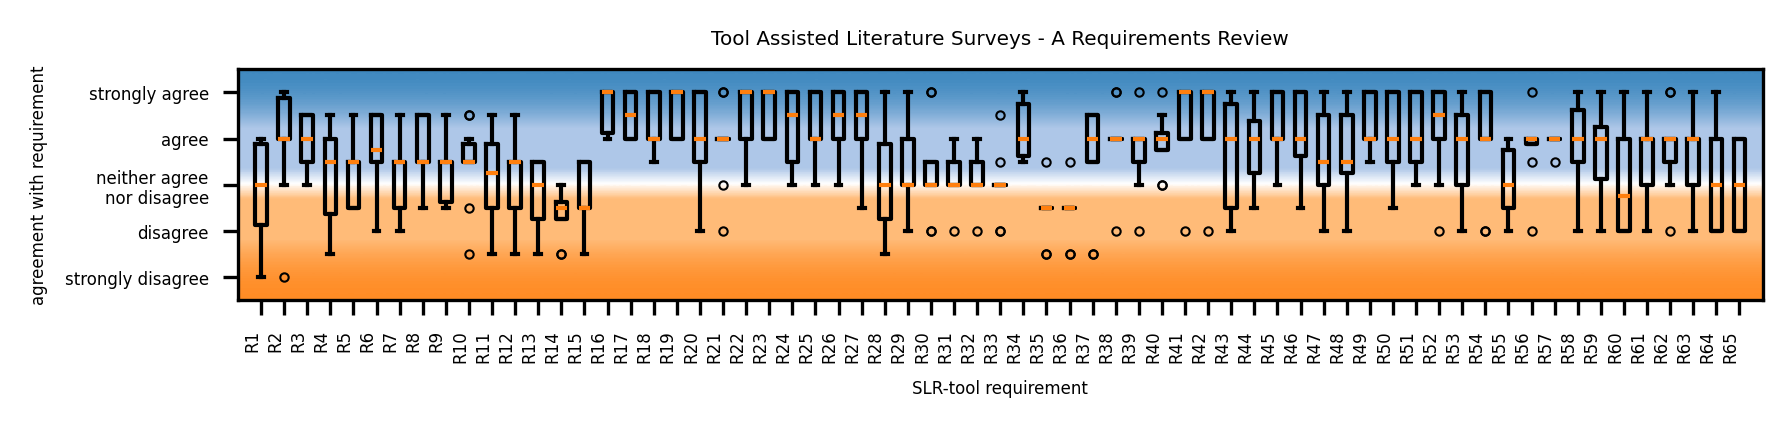

Reply 23 is invalid because age is 3
Survey 628237 was viewed by 75 people.
Survey 628237 has been started by 57 people.
Survey 628237 has been completed by 29 respondents.
Survey 628237 has 28 valid and 1 invalid replies.
11 tools have been evaluated, 5 of them by multiple replies.
SWARM-SLR has been evaluated by 8 replies.
SWARM-SLR has been evaluated for 40 minutes on average (16, 39, 39, 60, 78, 35, 13, 40).


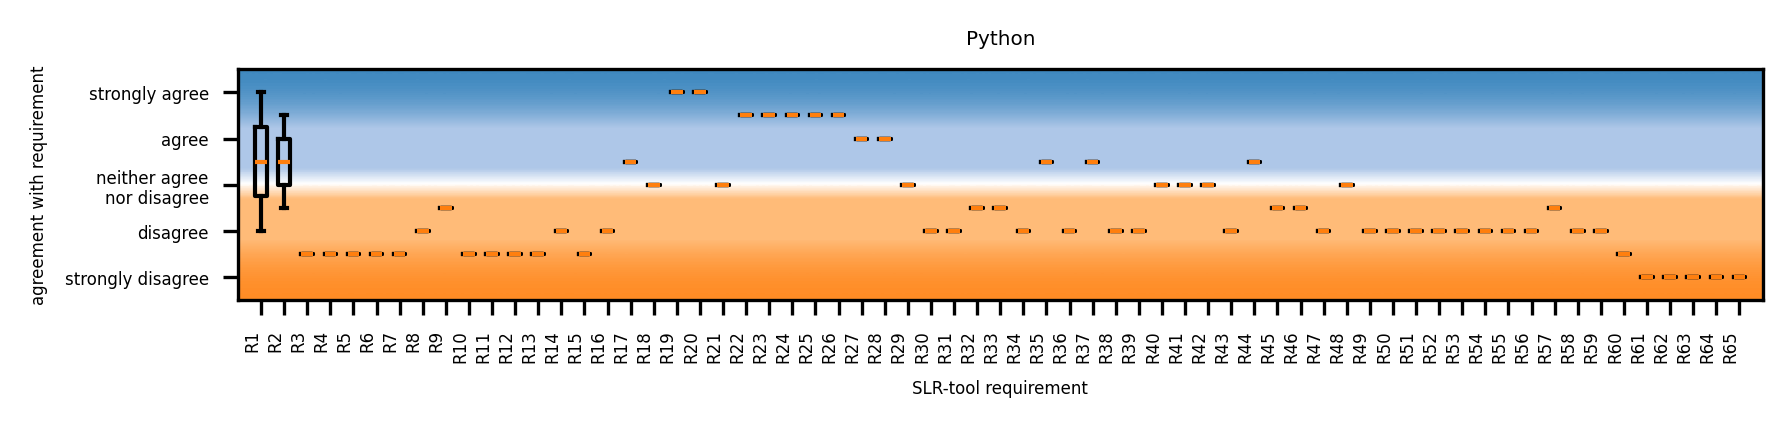

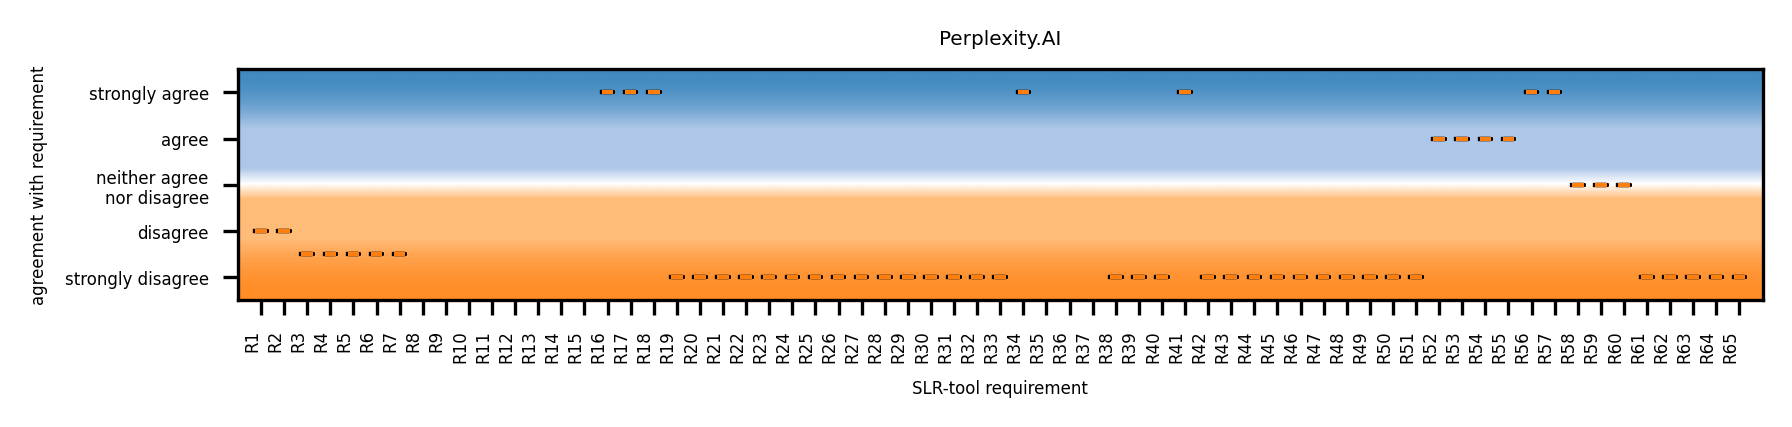

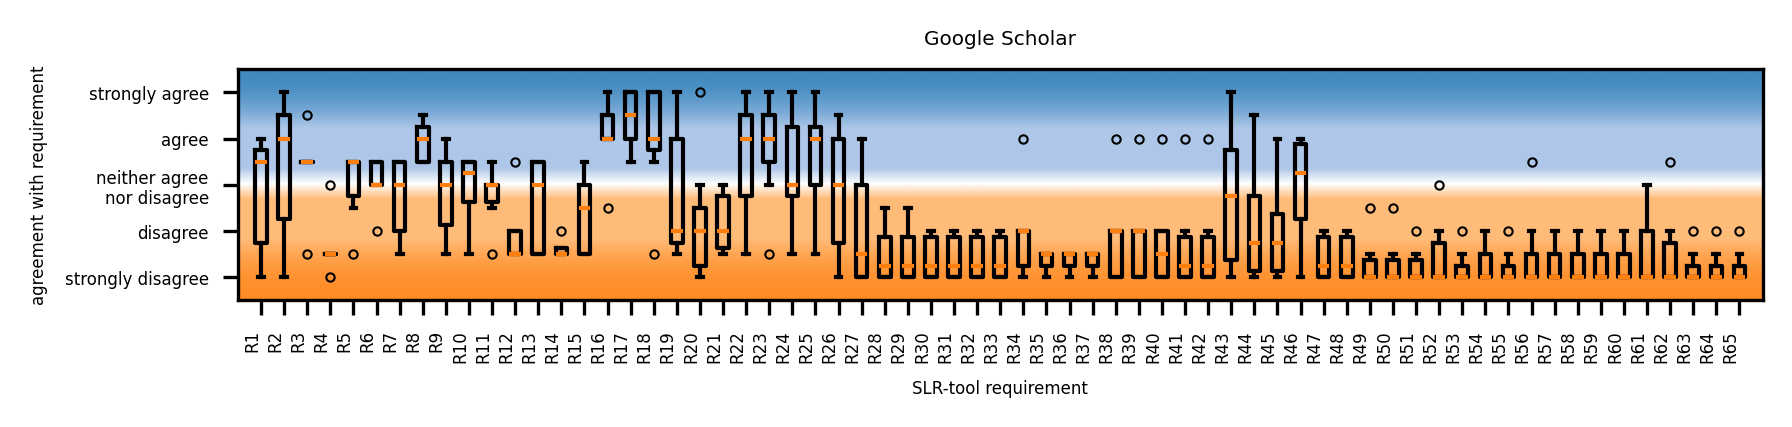

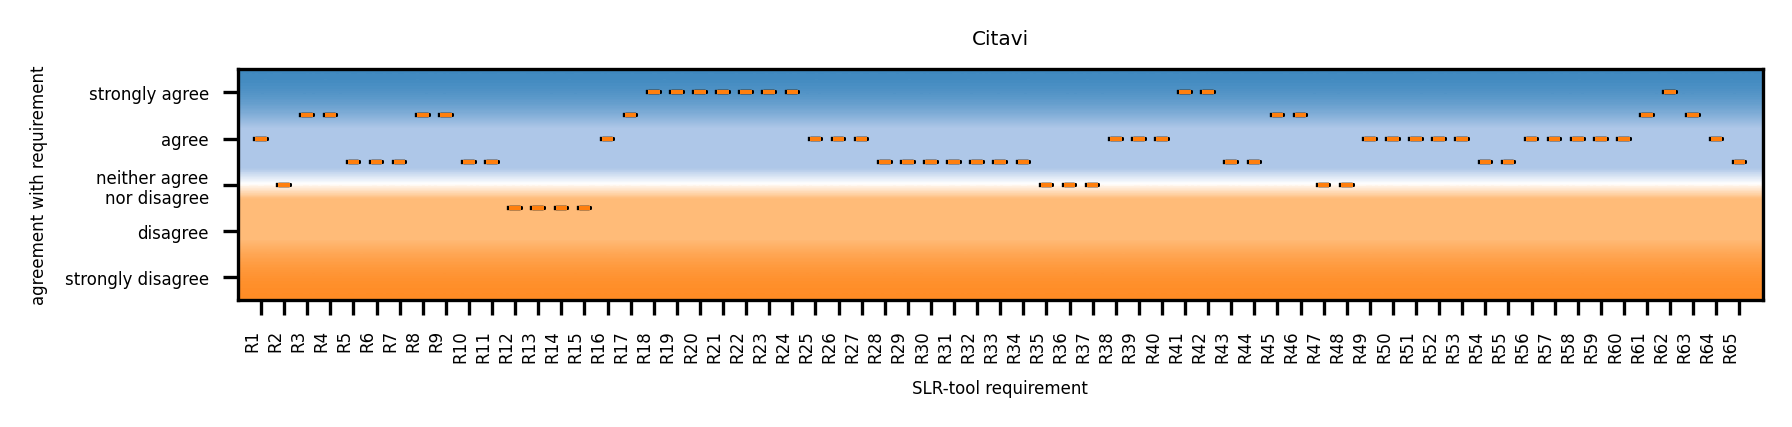

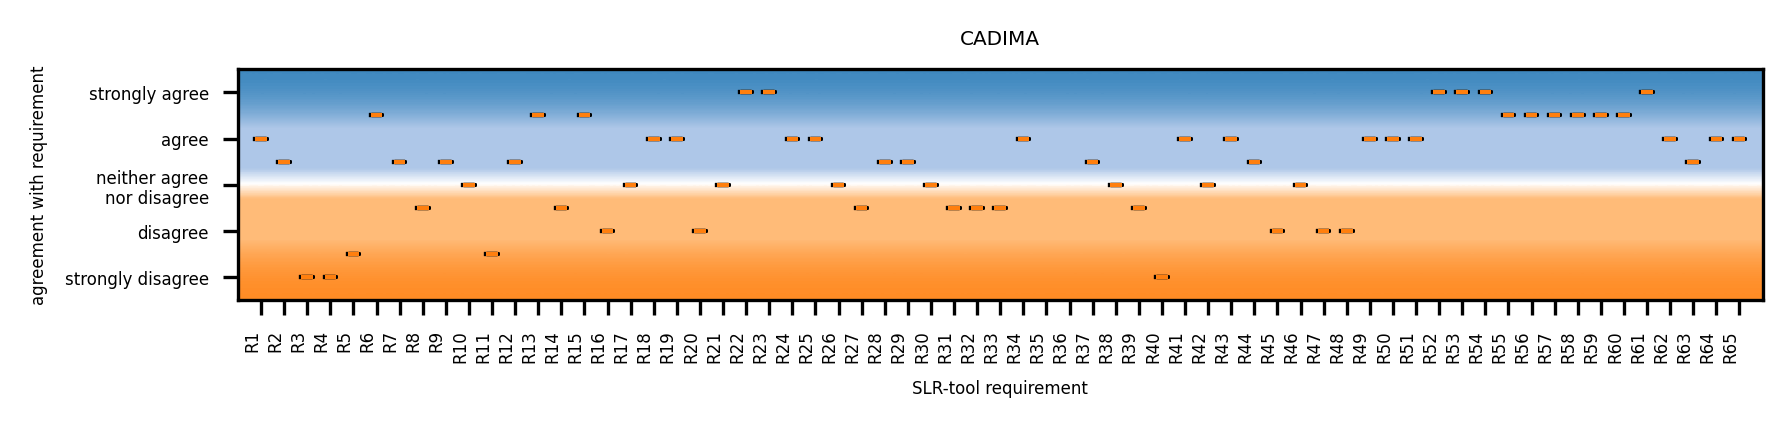

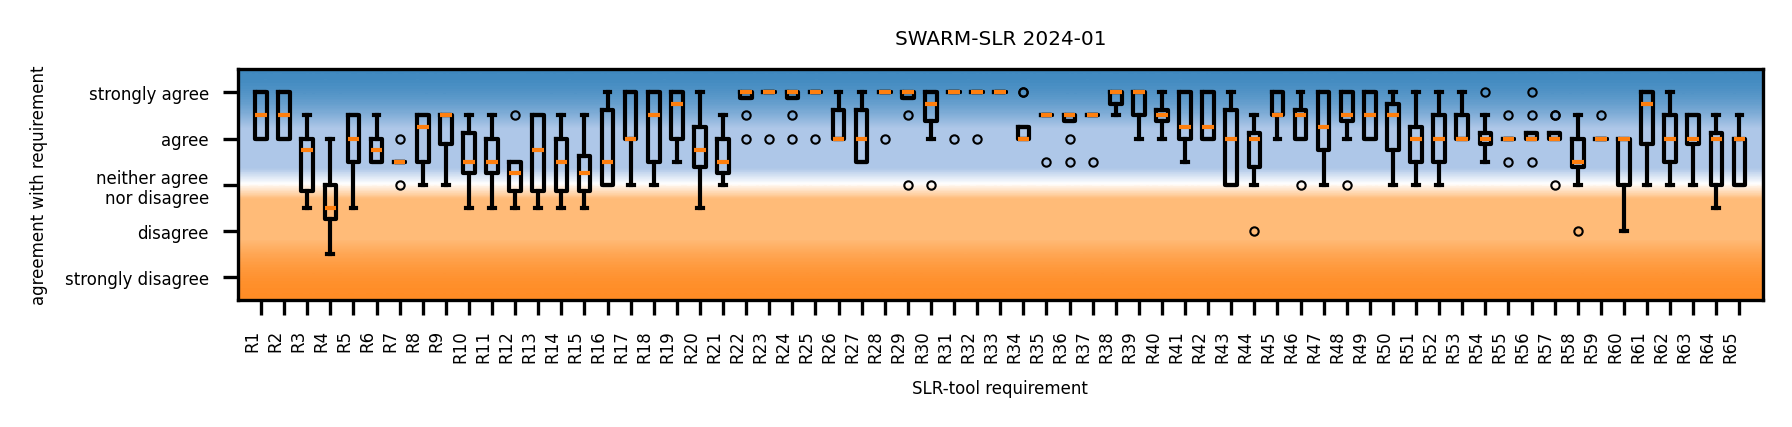

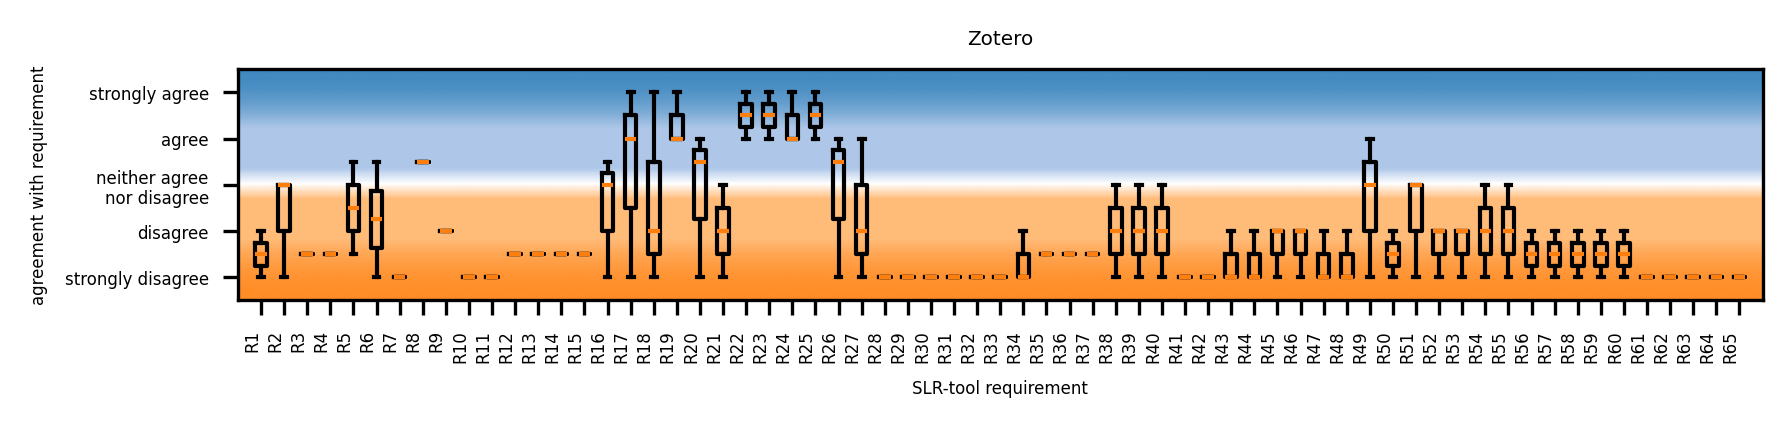

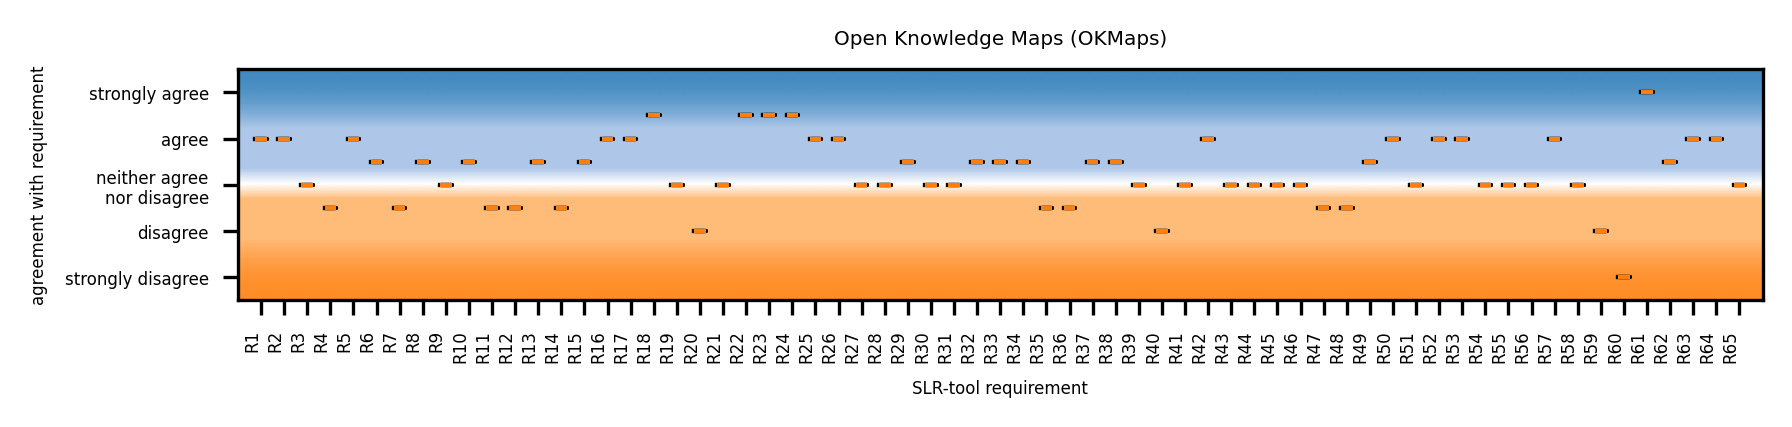

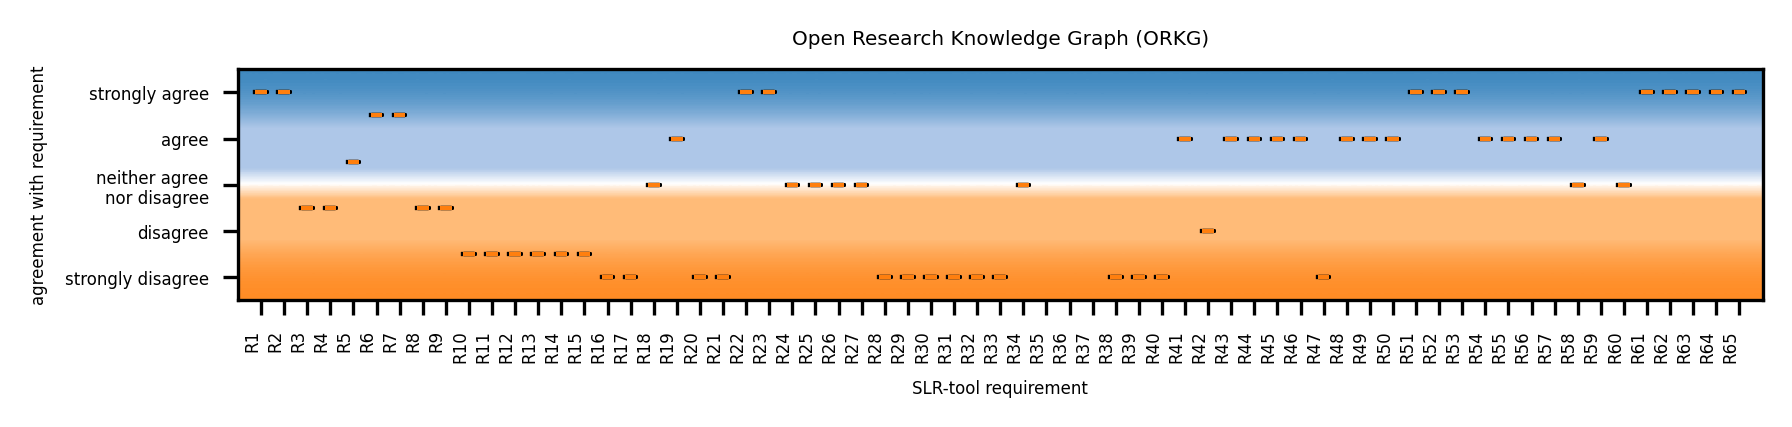

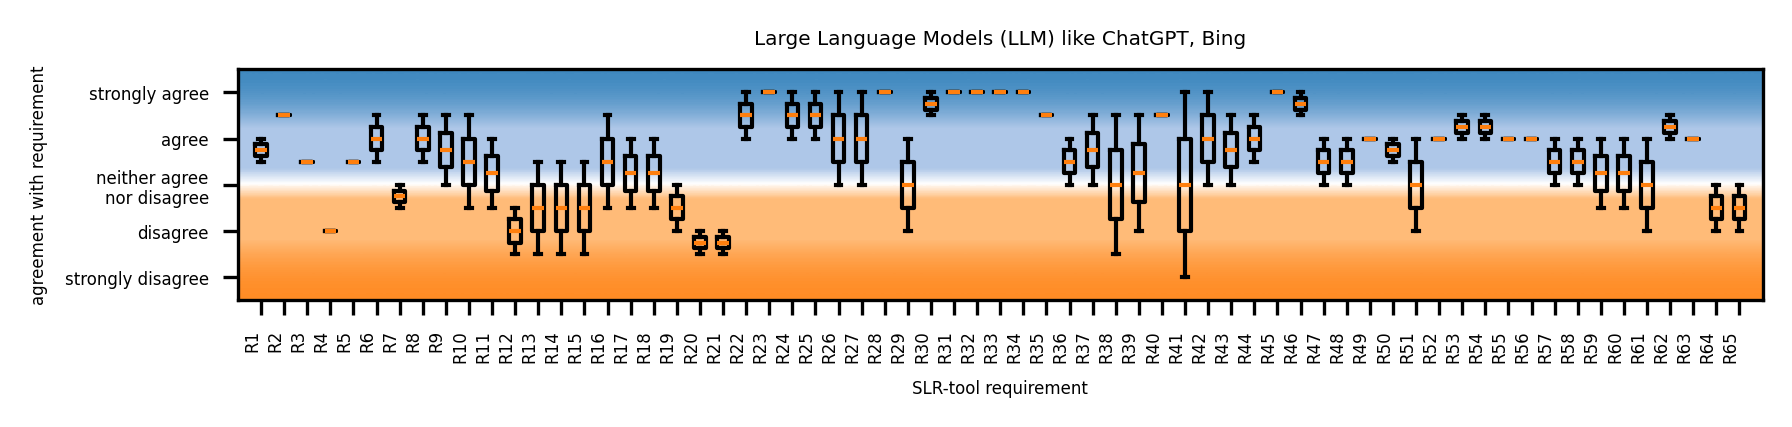

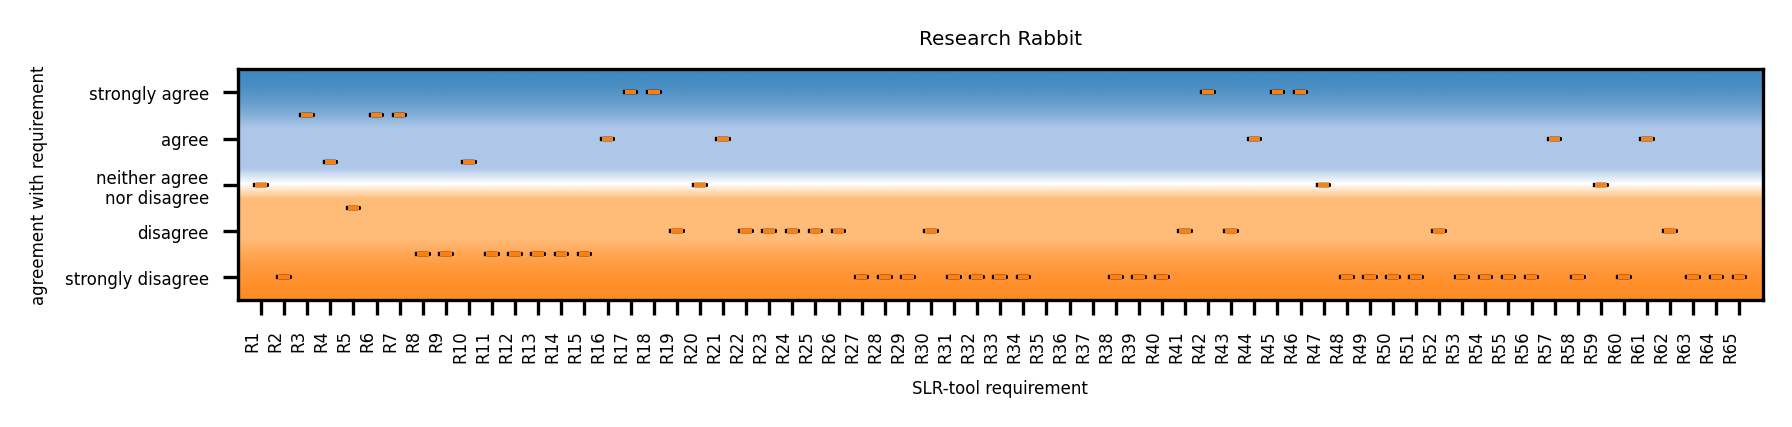

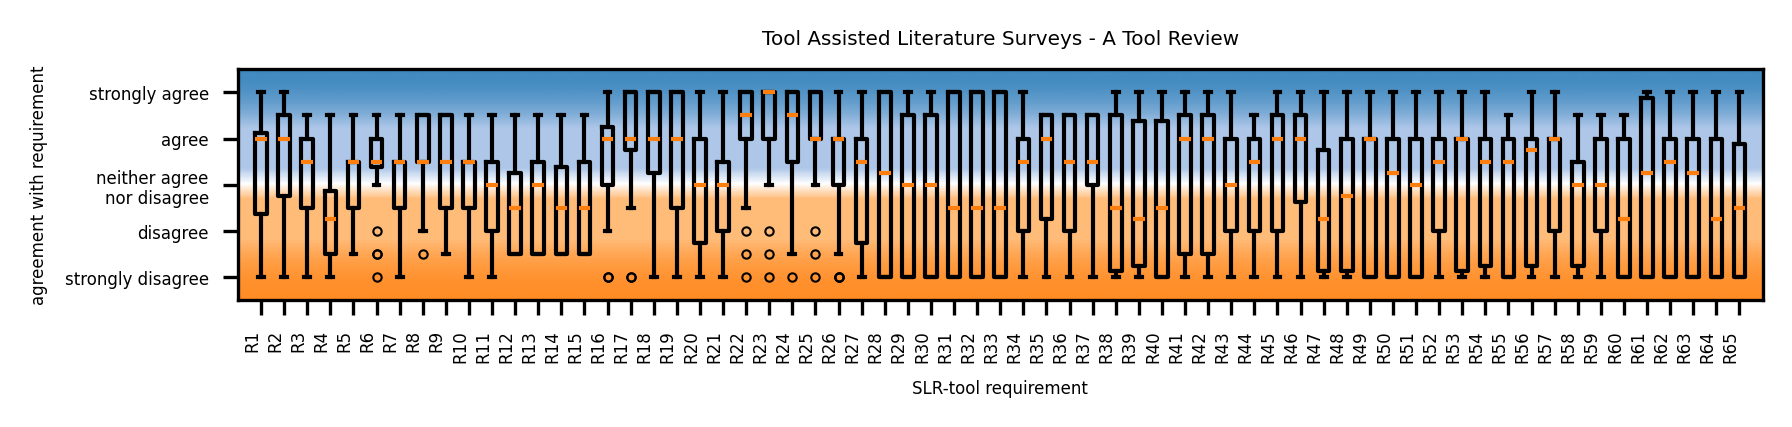

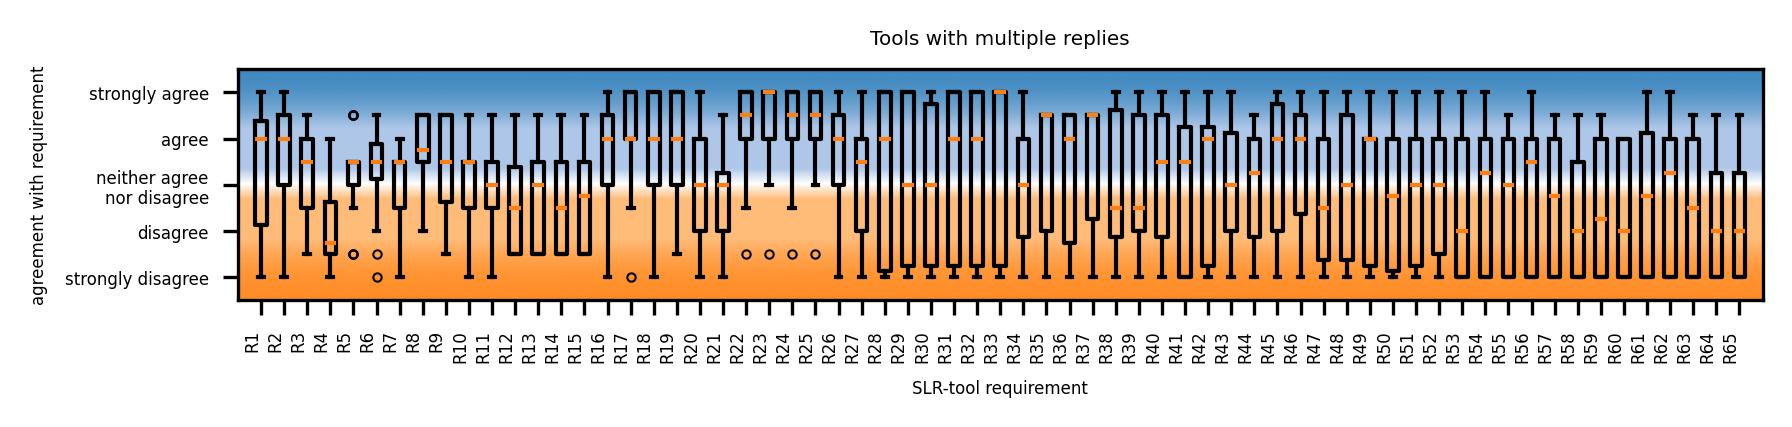

In [5]:
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import numpy as np


def create_box_plot(replies:List[Reply], vert=True, title=""):
    title = title if title else "Boxplot"
    if title == "tool":
        title = replies[0].tool
    elif title == "tools":
        title = 'Tool Assisted Literature Surveys - A Tool Review'
    elif title == "requirements":
        title = 'Tool Assisted Literature Surveys - A Requirements Review'

    data = []
    for reply in replies:
        data_for_box_plot(data, reply)
    labels = labels_for_box_plot(data=data)
    font = {'size'   : 4}
    # plt.minorticks_on()


    plt.rc('font', **font)
    c = ["#FF7F0E","#FFBB78","#FFBB78","white","#AEC7E8","#AEC7E8","#1F77B4"]
    v = [0,.175,.4,.5,0.6,.825,1.]
    l = list(zip(v,c))

    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

    # agreement = ["strongly agree", "", "agree", "", "neither agree\nnor disagree", "", "disagree", "", "strongly disagree"]
    agreement = ["strongly agree", "agree", "neither agree\nnor disagree", "disagree", "strongly disagree"]

    if vert:
        fig, ax = plt.subplots(dpi=300, figsize=(30, 1))
        plotlim = plt.xlim(0,len(data)+1) + plt.ylim(10,0)  

        ax.imshow([[0.5,0.5],[0,0]], cmap=cmap, interpolation='bicubic', extent=plotlim)  
        
        ax.set_ylabel('agreement with requirement')
        # set the x ticks from 1 to 9
        # ax.set_yticks(range(1,10))
        ax.set_yticks([1, 3, 5, 7, 9])
        ax.set_yticklabels(agreement)

        ax.set_xlabel('SLR-tool requirement')
        plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

    else:
        fig, ax = plt.subplots(dpi=300, figsize=(1, 30))
        plotlim = plt.xlim(1,9) + plt.ylim(len(data),0)  

        ax.imshow([[1,0],[1,0]], cmap=cmap, interpolation='bicubic', extent=plotlim)  
      
        ax.set_xlabel('Values')

        ax.set_ylabel('Requirement')

    ax.set_title(title)

    flierprops = dict(marker='o', markerfacecolor='none', markersize=2,
                  linestyle='none', markeredgecolor='black', markeredgewidth=0.5)

    ax.boxplot(data, vert=vert, labels=labels, flierprops=flierprops)


    # ax.legend(labels, title='Categories', loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()
    path = os.path.join(bnw_data_path, "visualization", title + '.png')
    fig.savefig(path, bbox_inches='tight')
    path = os.path.join(bnw_data_path, "visualization", title + '.svg')
    fig.savefig(path, bbox_inches='tight')

def data_for_box_plot(data, reply:Reply = None):
    for i, score in enumerate(reply.scores):
        res = None
        if score:
            res = int(score[1:])
            # max score is 9. If score is 10, it means the user did not answer the question
            if res == 10:
                res = None
        if i >= len(data):
            data.append([])
        if res:
            data[i].append(res)
    return data

def labels_for_box_plot(data:List = None, labels:List[str] = None, reply:Reply = None):
    labels = [] if labels is None else labels
    if not labels:
        for i in range(len(data)):
            labels.append(f"R{i+1}")
    return labels

# def is_invalid(reply:Reply):
def is_invalid(reply:Reply):
    # it is unrealistic to expect a minor to have experience on SLR
    if reply.age and int(reply.age) < 18:
        print(f"Reply {reply.response_id} is invalid because age is {reply.age}")
        return True
    # it is unrealistic to finish the survey in less than 60 seconds
    if float(reply.time.total_time) < 60:
        print(f"Reply {reply.response_id} is invalid because total time is {reply.time.total_time}")
        return True
    return False

for survey in surveys:
    # labels = survey.labels
    if survey.type == "555283":
        # Requirements survey. all we need is one big graphic.
        valid = []
        for reply in survey.replies:
            if is_invalid(reply):
                continue
            valid.append(reply)
            
        print(f"Survey {survey.type} was viewed by {survey.viewed_counter} people.")
        print(f"Survey {survey.type} has been started by {survey.started_counter} people.")
        print(f"Survey {survey.type} has been completed by {len(survey.replies)} respondents.")
        print(f"Survey {survey.type} has {len(valid)} valid and {len(survey.replies) - len(valid)} invalid replies.")
        create_box_plot(valid, title="requirements")
        continue
    elif survey.type == "628237":
        data = []
        valid = []
        tool_dict = {}
        for reply in survey.replies:
            if is_invalid(reply):
                continue
            if reply.tool not in tool_dict:
                tool_dict[reply.tool] = []
            tool_dict[reply.tool].append(reply)
            valid.append(reply)

        multiple_replies = []
        multiple_replies_count = 0
        swarm_slr_replies = []
        for tool, replies in tool_dict.items():
            if len(replies) > 1:
                multiple_replies += replies
                multiple_replies_count += 1
            if "SWARM-SLR" in tool:
                swarm_slr_replies += replies
                
        # calculate the average time for SWARM-SLR
        time_taken = [float(reply.time.total_time) for reply in swarm_slr_replies]
        total_time = sum(time_taken)
        average_time = total_time / len(time_taken)
        total_time_minutes = round(total_time / 60)
        average_time_minutes = round(average_time / 60)

        print(f"Survey {survey.type} was viewed by {survey.viewed_counter} people.")
        print(f"Survey {survey.type} has been started by {survey.started_counter} people.")
        print(f"Survey {survey.type} has been completed by {len(survey.replies)} respondents.")
        print(f"Survey {survey.type} has {len(valid)} valid and {len(survey.replies) - len(valid)} invalid replies.")
        print(f"{len(tool_dict)} tools have been evaluated, {multiple_replies_count} of them by multiple replies.")
        print(f"SWARM-SLR has been evaluated by {len(swarm_slr_replies)} replies.")
        print(f"SWARM-SLR has been evaluated for {average_time_minutes} minutes on average ({', '.join([str(round(t/60)) for t in time_taken])}).")

        for tool, replies in tool_dict.items():
            create_box_plot(replies, title="tool")
        create_box_plot(valid, title="tools")

        create_box_plot(multiple_replies, title="Tools with multiple replies")
        # plot_2d(valid)
        # plot_grouped_bar(valid)
    else:
        continue